In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")

print("Path to dataset files:", path)

/home/yanbo.wang/data/anaconda3/envs/inv_opt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 325M/325M [08:05<00:00, 702kB/s]  

Extracting files...


Path to dataset files: /home/yanbo.wang/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4


In [13]:
# importing basic libraries

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob ## glob is used to retrieve files 

from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ---------------------------- Scikit‑learn imports ---------------------------
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# ----------------------------- scikit‑image HOG ------------------------------
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog
from tqdm import tqdm

# --------------------------- PyTorch / TorchVision ---------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
# set seed
np.random.seed(42)

In [14]:
from PIL import Image

directory_benign_train = '/home/yanbo.wang/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4/train/benign'
directory_malignant_train = '/home/yanbo.wang/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4/train/malignant'
directory_benign_test = '/home/yanbo.wang/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4/test/benign'
directory_malignant_test = '/home/yanbo.wang/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4/test/malignant'

## Loading images and converting them to numpy array using their RGB value
read = lambda imname: np.asarray(Image.open(imname).convert('RGB'))
# np.asarray converts the objects into array/list

# Loading train images
img_benign_train = [read(os.path.join(directory_benign_train, filename)) for filename in os.listdir(directory_benign_train)]
img_malignant_train = [read(os.path.join(directory_malignant_train, filename)) for filename in os.listdir(directory_malignant_train)]

# Loading test images
img_benign_test = [read(os.path.join(directory_benign_test, filename)) for filename in os.listdir(directory_benign_test)]
img_malignant_test = [read(os.path.join(directory_malignant_test, filename)) for filename in os.listdir(directory_malignant_test)]

#img_benign_train
type(img_benign_train)

list

In [15]:
# Converting list to numpy array for faster and more convenient operations going forward

X_benign_train = np.array(img_benign_train, dtype='uint8')
X_malignant_train = np.array(img_malignant_train, dtype='uint8')

X_benign_test = np.array(img_benign_test, dtype='uint8')
X_malignant_test = np.array(img_malignant_test, dtype='uint8')

type(X_benign_train)

numpy.ndarray

In [16]:
## Creating labels: benign is 0 and malignant is 1

y_benign_train = np.zeros(X_benign_train.shape[0])
y_malignant_train = np.ones(X_malignant_train.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

y_malignant_train

array([1., 1., 1., ..., 1., 1., 1.], shape=(1197,))

In [17]:
## Merge data to form complete training and test sets
# axis = 0 means rows

X_train = np.concatenate((X_benign_train, X_malignant_train), axis=0) 
y_train = np.concatenate((y_benign_train, y_malignant_train), axis=0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)

print("Shape of X_train: ", X_train.shape) # one image constitutes to (224, 224, 3) and we have 2637 total images in training set
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

y_test

Shape of X_train:  (2637, 224, 224, 3)
Shape of y_train:  (2637,)
Shape of X_test:  (660, 224, 224, 3)
Shape of y_test:  (660,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [18]:
s1 = np.arange(X_train.shape[0])
np.random.shuffle(s1)
X_train = X_train[s1]
y_train = y_train[s1]

s2 = np.arange(X_test.shape[0])
np.random.shuffle(s2)
X_test = X_test[s2]
y_test = y_test[s2]

In [19]:
print("Shuffle orders example: ", s1)

Shuffle orders example:  [2297 1421 1057 ... 1130 1294  860]


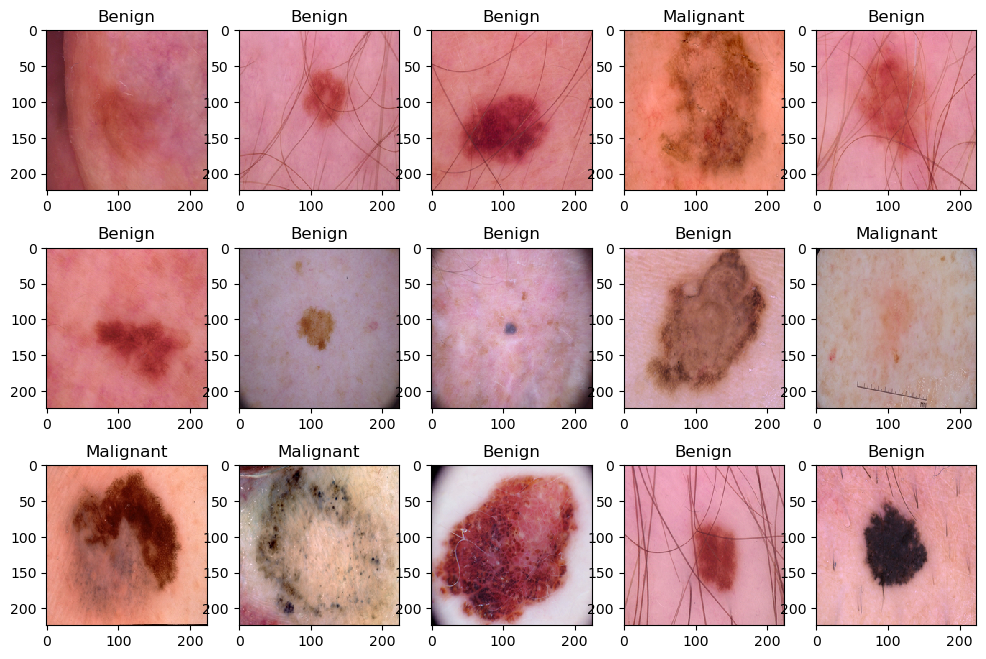

In [20]:
fig = plt.figure(figsize=(12,8))
columns = 5
rows = 3

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [21]:
# ---------------------------------------------------------------------------
# 1. Dataset – assumes arrays X_train, X_test (N, 224, 224, 3) and labels
#    y_train, y_test (N,) already exist in memory from your previous code.
# ---------------------------------------------------------------------------

class SkinDataset(Dataset):
    """Wrap numpy arrays so they are compatible with torch DataLoader."""

    def __init__(self, images: np.ndarray, labels: np.ndarray, transform=None):
        assert images.shape[0] == labels.shape[0], "Images & labels mismatch"
        self.images = images
        self.labels = labels.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


In [22]:
# Data transforms
train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
val_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

full_ds = SkinDataset(X_train, y_train, transform=train_tfms)
test_ds = SkinDataset(X_test, y_test, transform=val_tfms)

train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")


Using device: cuda:0



In [26]:
def calc_rates(tn, fp, fn, tp):
    tpr = tp / (tp + fn) if (tp + fn) else 0  # Sensitivity / Recall
    tnr = tn / (tn + fp) if (tn + fp) else 0  # Specificity
    fpr = fp / (fp + tn) if (fp + tn) else 0
    fnr = fn / (fn + tp) if (fn + tp) else 0
    return tpr, tnr, fpr, fnr

In [27]:
# ---------------------------------------------------------------------------
# 2. HOG Feature Extraction + LinearSVC Baseline
# ---------------------------------------------------------------------------

# HOG parameters – feel free to tweak

HOG_RESIZE   = (128,128)
HOG_PIX_CEL  = (8,8)
HOG_CELL_BLK = (2,2)
HOG_ORIENT   = 9

def extract_hog(img):
    gray = rgb2gray(resize(img, HOG_RESIZE, anti_aliasing=True))
    return hog(gray, orientations=HOG_ORIENT,
               pixels_per_cell=HOG_PIX_CEL, cells_per_block=HOG_CELL_BLK,
               block_norm="L2-Hys", transform_sqrt=True, feature_vector=True)

print("*** Extracting HOG features (train) ***")
X_train_hog = np.array([extract_hog(im) for im in tqdm(X_train)])
print("*** Extracting HOG features (test)  ***")
X_test_hog  = np.array([extract_hog(im) for im in tqdm(X_test)])

print(f"HOG feature dimension: {X_train_hog.shape[1]}")

hog_svm = make_pipeline(StandardScaler(),
                        LinearSVC(C=1.0, dual=False, max_iter=5000, random_state=42))
print("\n*** Training HOG + LinearSVC ***")
hog_svm.fit(X_train_hog, y_train)

hog_preds = hog_svm.predict(X_test_hog)
print("\n--- HOG + SVM Classification Report ---")
print(classification_report(y_test, hog_preds, target_names=["Benign","Malignant"]))

hog_acc = accuracy_score(y_test, hog_preds)
hog_tn, hog_fp, hog_fn, hog_tp = confusion_matrix(y_test, hog_preds).ravel()
hog_tpr, hog_tnr, hog_fpr, hog_fnr = calc_rates(hog_tn, hog_fp, hog_fn, hog_tp)
print(f"HOG+SVM Test Accuracy: {hog_acc:.4f}  TP:{hog_tp} TN:{hog_tn} FP:{hog_fp} FN:{hog_fn}")
print(f"Rates  →  TPR:{hog_tpr:.3f}  TNR:{hog_tnr:.3f}  FPR:{hog_fpr:.3f}  FNR:{hog_fnr:.3f}\n")

*** Extracting HOG features (train) ***


100%|██████████| 2637/2637 [00:32<00:00, 80.39it/s]


*** Extracting HOG features (test)  ***


100%|██████████| 660/660 [00:07<00:00, 90.77it/s]


HOG feature dimension: 8100

*** Training HOG + LinearSVC ***

--- HOG + SVM Classification Report ---
              precision    recall  f1-score   support

      Benign       0.70      0.69      0.70       360
   Malignant       0.63      0.64      0.64       300

    accuracy                           0.67       660
   macro avg       0.67      0.67      0.67       660
weighted avg       0.67      0.67      0.67       660

HOG+SVM Test Accuracy: 0.6682  TP:191 TN:250 FP:110 FN:109
Rates  →  TPR:0.637  TNR:0.694  FPR:0.306  FNR:0.363



In [28]:
# ---------------------------------------------------------------------------
# 3. Simple 3‑layer CNN
# ---------------------------------------------------------------------------

class SimpleCNN(nn.Module):
    """A minimal 3‑convolutional‑layer CNN for binary classification."""

    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [29]:
# ---------------------------------------------------------------------------
# 4. Training & Evaluation helpers (same as before)
# ---------------------------------------------------------------------------

def train_model(model, criterion, optimizer, n_epochs=10, name="model"):
    hist = {k:[] for k in ["train_loss","val_loss","train_acc","val_acc"]}
    model.to(device)
    for ep in range(n_epochs):
        model.train(); tl=tc=tot=0
        for imgs,lbls in train_loader:
            imgs,lbls = imgs.to(device), lbls.unsqueeze(1).to(device)
            optimizer.zero_grad(); out = model(imgs)
            loss = criterion(out,lbls); loss.backward(); optimizer.step()
            tl += loss.item()*imgs.size(0)
            preds = (torch.sigmoid(out)>=0.5).float()
            tc += (preds==lbls).sum().item(); tot+=lbls.size(0)
        hist["train_loss"].append(tl/tot); hist["train_acc"].append(tc/tot)
        # val
        model.eval(); vl=vc=vt=0
        with torch.no_grad():
            for imgs,lbls in val_loader:
                imgs,lbls = imgs.to(device), lbls.unsqueeze(1).to(device)
                out = model(imgs); loss = criterion(out,lbls)
                vl+=loss.item()*imgs.size(0)
                preds=(torch.sigmoid(out)>=0.5).float()
                vc += (preds==lbls).sum().item(); vt+=lbls.size(0)
        hist["val_loss"].append(vl/vt); hist["val_acc"].append(vc/vt)
        print(f"{name} | Ep {ep+1}/{n_epochs} TrainAcc:{hist['train_acc'][-1]:.3f} ValAcc:{hist['val_acc'][-1]:.3f}")
    return hist

def preds_labels(model):
    model.eval(); ps,ls=[],[]
    with torch.no_grad():
        for imgs,lbls in test_loader:
            imgs=imgs.to(device); out=model(imgs)
            ps.extend((torch.sigmoid(out)>=0.5).cpu().numpy().astype(int).ravel())
            ls.extend(lbls.numpy().astype(int))
    return np.array(ps), np.array(ls)

In [30]:
print("*** Training Simple CNN ***")
cnn = SimpleCNN()
cnn_hist = train_model(cnn, nn.BCEWithLogitsLoss(), optim.Adam(cnn.parameters(), lr=1e-4), 10, "SimpleCNN")

cnn_preds, cnn_labels = preds_labels(cnn)
print("\n--- Simple CNN Classification Report ---")
print(classification_report(cnn_labels, cnn_preds, target_names=["Benign","Malignant"]))

cnn_acc = accuracy_score(cnn_labels, cnn_preds)
cnn_tn, cnn_fp, cnn_fn, cnn_tp = confusion_matrix(cnn_labels, cnn_preds).ravel()
cnn_tpr, cnn_tnr, cnn_fpr, cnn_fnr = calc_rates(cnn_tn, cnn_fp, cnn_fn, cnn_tp)
print(f"SimpleCNN Test Accuracy: {cnn_acc:.4f}  TP:{cnn_tp} TN:{cnn_tn} FP:{cnn_fp} FN:{cnn_fn}")
print(f"Rates  →  TPR:{cnn_tpr:.3f}  TNR:{cnn_tnr:.3f}  FPR:{cnn_fpr:.3f}  FNR:{cnn_fnr:.3f}\n")


*** Training Simple CNN ***
SimpleCNN | Ep 1/10 TrainAcc:0.719 ValAcc:0.767
SimpleCNN | Ep 2/10 TrainAcc:0.787 ValAcc:0.820
SimpleCNN | Ep 3/10 TrainAcc:0.791 ValAcc:0.824
SimpleCNN | Ep 4/10 TrainAcc:0.819 ValAcc:0.818
SimpleCNN | Ep 5/10 TrainAcc:0.827 ValAcc:0.824
SimpleCNN | Ep 6/10 TrainAcc:0.827 ValAcc:0.809
SimpleCNN | Ep 7/10 TrainAcc:0.836 ValAcc:0.833
SimpleCNN | Ep 8/10 TrainAcc:0.840 ValAcc:0.837
SimpleCNN | Ep 9/10 TrainAcc:0.839 ValAcc:0.824
SimpleCNN | Ep 10/10 TrainAcc:0.850 ValAcc:0.848

--- Simple CNN Classification Report ---
              precision    recall  f1-score   support

      Benign       0.93      0.77      0.84       360
   Malignant       0.77      0.93      0.84       300

    accuracy                           0.84       660
   macro avg       0.85      0.85      0.84       660
weighted avg       0.86      0.84      0.84       660

SimpleCNN Test Accuracy: 0.8409  TP:279 TN:276 FP:84 FN:21
Rates  →  TPR:0.930  TNR:0.767  FPR:0.233  FNR:0.070



In [31]:
# ---------------------------------------------------------------------------
# 6. Fine‑tune ResNet‑18
# ---------------------------------------------------------------------------

print("*** Fine‑tuning ResNet‑18 ***")
# Load ImageNet‑pretrained backbone
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all convolutional layers so we only train the classifier head
for param in resnet18.parameters():
    param.requires_grad = False

# Replace the final fully‑connected layer with a single‑node classifier
resnet18.fc = nn.Linear(resnet18.fc.in_features, 1)

# Train only the new FC layer
res_hist = train_model(
    resnet18,
    nn.BCEWithLogitsLoss(),
    optim.Adam(resnet18.fc.parameters(), lr=1e-4),
    n_epochs=10,
    name="ResNet18"
)

# Evaluate on the test set
res_preds, res_labels = preds_labels(resnet18)

print("\n--- ResNet‑18 Classification Report ---")
print(classification_report(res_labels, res_preds,
                            target_names=["Benign", "Malignant"]))

res_acc = accuracy_score(res_labels, res_preds)
res_tn, res_fp, res_fn, res_tp = confusion_matrix(res_labels, res_preds).ravel()
res_tpr, res_tnr, res_fpr, res_fnr = calc_rates(res_tn, res_fp, res_fn, res_tp)

print(f"ResNet18 Test Accuracy: {res_acc:.4f}  TP:{res_tp}  TN:{res_tn}  FP:{res_fp}  FN:{res_fn}")
print(f"Rates → TPR:{res_tpr:.3f}  TNR:{res_tnr:.3f}  FPR:{res_fpr:.3f}  FNR:{res_fnr:.3f}\n")


*** Fine‑tuning ResNet‑18 ***
ResNet18 | Ep 1/10 TrainAcc:0.543 ValAcc:0.629
ResNet18 | Ep 2/10 TrainAcc:0.666 ValAcc:0.752
ResNet18 | Ep 3/10 TrainAcc:0.715 ValAcc:0.777
ResNet18 | Ep 4/10 TrainAcc:0.750 ValAcc:0.784
ResNet18 | Ep 5/10 TrainAcc:0.770 ValAcc:0.797
ResNet18 | Ep 6/10 TrainAcc:0.777 ValAcc:0.790
ResNet18 | Ep 7/10 TrainAcc:0.795 ValAcc:0.790
ResNet18 | Ep 8/10 TrainAcc:0.790 ValAcc:0.820
ResNet18 | Ep 9/10 TrainAcc:0.796 ValAcc:0.812
ResNet18 | Ep 10/10 TrainAcc:0.796 ValAcc:0.826

--- ResNet‑18 Classification Report ---
              precision    recall  f1-score   support

      Benign       0.90      0.74      0.81       360
   Malignant       0.74      0.90      0.81       300

    accuracy                           0.81       660
   macro avg       0.82      0.82      0.81       660
weighted avg       0.83      0.81      0.81       660

ResNet18 Test Accuracy: 0.8121  TP:269  TN:267  FP:93  FN:31
Rates → TPR:0.897  TNR:0.742  FPR:0.258  FNR:0.103



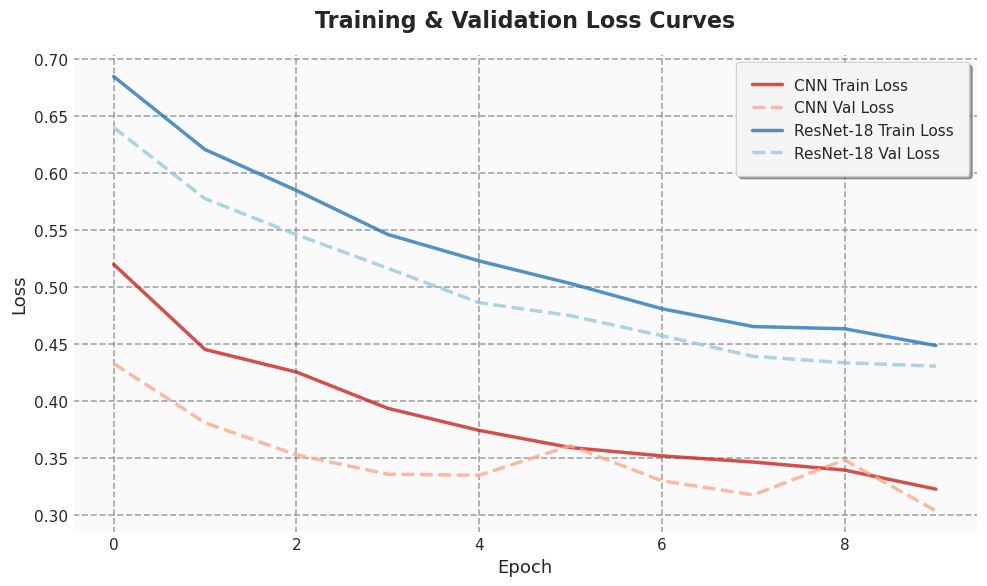

In [38]:
# --------------------------------------------------------------------------- #
# Plot Loss Curves for CNN & ResNet-18 
# --------------------------------------------------------------------------- #

import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 11

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)


colors = {
    'cnn_train': '#C82423',    
    'cnn_val': '#F8AC8C',     
    'resnet_train': '#2878B5', 
    'resnet_val': '#9AC9DB'    
}


ax.plot(cnn_hist["train_loss"], 
        label="CNN Train Loss", 
        color=colors['cnn_train'], 
        linewidth=2.5, 
        alpha=0.8)

ax.plot(cnn_hist["val_loss"], 
        label="CNN Val Loss", 
        color=colors['cnn_val'], 
        linewidth=2.5, 
        alpha=0.8,
        linestyle='--') 

ax.plot(res_hist["train_loss"], 
        label="ResNet-18 Train Loss", 
        color=colors['resnet_train'], 
        linewidth=2.5, 
        alpha=0.8)

ax.plot(res_hist["val_loss"], 
        label="ResNet-18 Val Loss", 
        color=colors['resnet_val'], 
        linewidth=2.5, 
        alpha=0.8,
        linestyle='--')  


ax.set_title("Training & Validation Loss Curves", 
             fontsize=16, 
             fontweight='bold', 
             pad=20)

ax.set_xlabel("Epoch", 
              fontsize=13, 
              fontweight='medium')

ax.set_ylabel("Loss", 
              fontsize=13, 
              fontweight='medium')


legend = ax.legend(loc='upper right', 
                   frameon=True, 
                   fancybox=True, 
                   shadow=True,
                   borderpad=1,
                   columnspacing=1.5)


legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)


ax.grid(True, alpha=0.7, linestyle='--', linewidth=1.2, color='gray')
ax.set_axisbelow(True)  


ax.set_facecolor('#FAFAFA')
fig.patch.set_facecolor('white')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)


plt.tight_layout()


plt.show()